<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/Grad-CAMoct1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Grad-CAM

*อ้างอิงการทำ Grad-CAM จาก https://github.com/khawajatalhahaseeb/Class-Activation-Map-Keras/blob/main/Class%20Activation%20Map.ipynb?fbclid=IwAR1-qtJZo1U6WVI0E1d48wVMWqbqjqLOiNAPS4lm2hA3Tt-jW8dIuhmhpNo *

*ลิ้งค์โมเดล https://drive.google.com/file/d/1tPy0DOrXT9ZBpMCsWKQGhqoI9ZedzhlP/view?usp=sharing*

In [1]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
import keras.backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
import tensorflow as tf
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import seaborn as sns
import cv2
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

In [24]:
# กำหนดโมเดล CNN ที่ต้องการ
model = keras.models.load_model('/content/drive/MyDrive/2022Project/for_code/Model/modelOCT.h5')

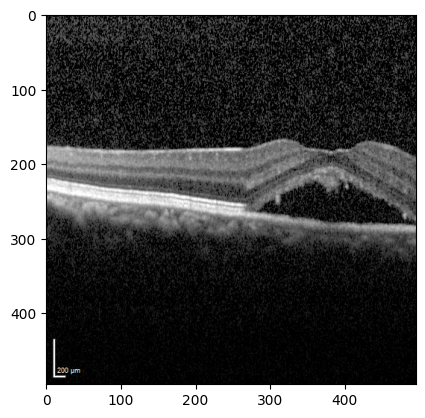

In [25]:
# นำภาพที่ต้องการทำ activation map มาเตรียม
img_path = ("/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png")  # ภาพที่ต้องการทำ activation map
img=mpimg.imread(img_path)
plt.imshow(img)

ปรับขนาดภาพให้พอดีกับขนาดอินพุตของโมเดล

In [26]:
img = load_img(img_path, target_size=(256, 256))

แปลงรูปภาพเป็นอาร์เรย์ numpy

In [27]:
x = img_to_array(img)

ปรับรูปร่างข้อมูลใหม่เป็น 'batch form' เพื่อให้โมเดลสามารถยอมรับได้

In [28]:
x = np.expand_dims(x, axis=0)

In [29]:
x.shape

(1, 256, 256, 3)

Preprocessing

In [30]:
x = preprocess_input(x)

Predictions

In [31]:
# กำหนดคลาส
imagenet_classes = ["CSC", "Normal", "PCV", "VKH"]

In [32]:
# Make a prediction
preds = model.predict(x)

1/1 [==============================] - 0s 384ms/step


In [33]:
# Find the class with the highest probability
class_index = np.argmax(preds[0])

In [34]:
# Print the class name
class_name = imagenet_classes[class_index]
print(f"Predicted class: {class_name}")

Predicted class: CSC


Getting the index of the prediction.

In [35]:
argmax = np.argmax(preds[0])

In [36]:
output = model.output[:, argmax]

Model Archtecture

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [38]:
last_conv_layer = model.get_layer('conv2d_2')

***ฟังก์ชัน tf.gradients ไม่สามารถใช้งานได้กับ Eager Execution. จึงใช้ tf.GradientTape แทน ซึ่งเป็นตัวควบคุมการคำนวณแบบ Gradient ใน Eager Execution***

In [39]:
# Define input and function
x = tf.constant(1.0)
y = x ** 2

# Use GradientTape to compute the gradient
with tf.GradientTape() as tape:
    grads = tape.gradient(y, x)
print(dy_dx)

# Print the gradient
print(grads)

tf.Tensor(6.0, shape=(), dtype=float32)
None


***ได้ค่า grads = none***

In [40]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

AttributeError: ignored

In [41]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

NameError: ignored

Plotting the Heatmap.

In [ ]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Load image and resize the heatmap.

In [ ]:
img = cv2.imread(img_path)

In [ ]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

Convert heatmap into 'RGB' and apply it to original Image.

In [ ]:
heatmap = np.uint8(255 * heatmap)

In [ ]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

Apply heatmap intensity factor.

In [ ]:
hif = .8

In [ ]:
superimposed_img = heatmap * hif + img

Save to disk and plot.

In [ ]:
output = 'read_image/output_sheep.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0, 'categories'])